In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from bcnf.simulation.physics import get_data
from bcnf.model.cnf import CondRealNVP
from bcnf.train.train import train_CondRealNVP
from bcnf.utils import partconv1d, get_gaussian_kernel

In [3]:
X, y = get_data(N=100)
X.shape, y.shape

((100, 50, 3), (100, 14))

In [4]:
feature_network = torch.nn.Sequential(
    torch.nn.Linear(X.shape[1] * X.shape[2], 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 14),
)

In [5]:
cnf = CondRealNVP(
    input_size=y.shape[1],
    hidden_size=32,
    n_epochs=5,
    n_conditions=feature_network[-1].out_features,
    feature_network=feature_network,
    dropout=0,
    device=device).to(device)

optimizer = torch.optim.Adam(cnf.parameters(), lr=1e-3)

In [6]:
X_tensor = torch.tensor(X.reshape(X.shape[0], -1), dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

print(f'{X_tensor.shape=}')
print(f'{y_tensor.shape=}')

X_tensor.shape=torch.Size([100, 150])
y_tensor.shape=torch.Size([100, 14])


In [7]:
loss_history = train_CondRealNVP(
    model=cnf,
    optimizer=optimizer,
    X_train=X_tensor,
    y_train=y_tensor,
    n_epochs=1000,
    batch_size=32);

Train: 5.6422: 100%|██████████| 1000/1000 [00:13<00:00, 71.83it/s]


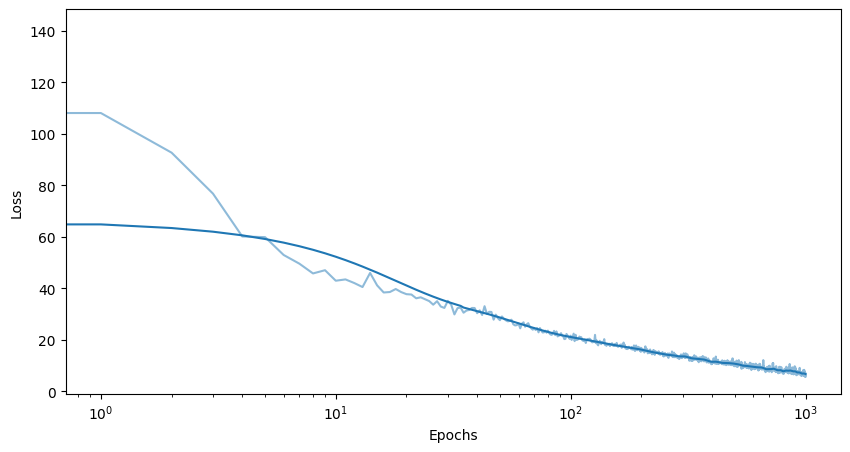

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(loss_history['train'], alpha=0.5, color='C0')
ax.plot(partconv1d(np.array(loss_history['train']), kernel=get_gaussian_kernel(sigma=10)), label='train', color='C0')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.set_xscale('log')

In [9]:
y_hat = cnf.sample(n_samples=100, y=X_tensor[0])
y_hat = y_hat.cpu().detach().numpy()
y_hat.shape

AttributeError: 'Linear' object has no attribute 'input_size'